In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from matplotlib import transforms

from sklearn.neighbors import NearestNeighbors

import os
import sys
from importlib import reload

# local imports 
import filters
import pore_c_utils as pcu
import binning_utils as binning

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession,chromEnd,chromStart
0,1,195154279,CM000994.3,NC_000067.7,195154279,0
1,2,181755017,CM000995.3,NC_000068.8,376909296,195154279
2,3,159745316,CM000996.3,NC_000069.7,536654612,376909296
3,4,156860686,CM000997.3,NC_000070.7,693515298,536654612
4,5,151758149,CM000998.3,NC_000071.7,845273447,693515298
5,6,149588044,CM000999.3,NC_000072.7,994861491,845273447
6,7,144995196,CM001000.3,NC_000073.7,1139856687,994861491
7,8,130127694,CM001001.3,NC_000074.7,1269984381,1139856687
8,9,124359700,CM001002.3,NC_000075.7,1394344081,1269984381
9,10,130530862,CM001003.3,NC_000076.7,1524874943,1394344081


In [3]:
def loadRawContactDirectory(dirpath, filetags, verbose=True):
    """A function to load a directory of contact tables"""
    results = {}
    for runId in filetags:
        df = pcu.loadContactTable(dirpath, runId)
        
        if verbose:
            print(f"{runId=} {df.shape=}")
        
        results[runId] = df
    return results
    

    
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
filetags = [f"run0{x}" for x in range(1, 8)]
rawCells = loadRawContactDirectory(dirpath, filetags)

print(f"{rawCells.keys()=}")

runId='run01' df.shape=(13386738, 38)
runId='run02' df.shape=(13046898, 38)
runId='run03' df.shape=(18685242, 38)
runId='run04' df.shape=(20486346, 38)
runId='run05' df.shape=(5043403, 38)
runId='run06' df.shape=(7310826, 38)
runId='run07' df.shape=(10525887, 38)
rawCells.keys()=dict_keys(['run01', 'run02', 'run03', 'run04', 'run05', 'run06', 'run07'])


In [4]:
def runAllFilters(cells, assembly, chromosome='NC_000068.8', verbose=True):
    """A function to filter all cells """
    
    results = {}
    
    for runId, df in cells.items():
        if verbose:
            print("------------------------------")
            print(f"filtering {runId=}")
    
        df = filters.adjacentContactFilter(df)
        df = filters.selfLoopFilter(df)
        df = filters.mapQFilter(df, lowerBound=60, upperBound=250)
        df = filters.distalContactFilter(df)
        df = filters.closeContactFilter(df)
        df = filters.duplicateContactFilter(df, retain=1)
        df = filters.ligationProductFilter(df, nProducts=4, verbose=False)

        df = filters.establishContactSupport(df, windowSize=1000000, 
                                             nContacts=2, 
                                             readSupport=False, 
                                             nReads=3)

        df = filters.supportedContactFilter(df, readSupport=False)
        
        if verbose:
            res = pcu.getSummary(df)
            pcu.printSummary(res)
            print()
            
        if chromosome is not None:
            df = filters.chromosomalFilter(df, assembly)
            df = filters.removeYChrom(df)
            df = pcu.filterChomosome(df, chromosome)
            
        results[runId] = df
        
    return results
    

filteredCellsChr2 = runAllFilters(rawCells,
                                  assembly, 
                                  chromosome='NC_000068.8', 
                                  verbose=True)  

print(f"{filteredCellsChr2.keys()=}")

------------------------------
filtering runId='run01'
Total Reads 18891 (1.000)
Singletons 15163 (0.803)
Pairs 2639 (0.140)
Multiway 1089 (0.058)
-- -- --
Total Contacts 24238 (1.000)
cis Contacts 22190 (0.916)
trans Contacts 2048 (0.084)
-- -- --
Total Contacts 24238 (1.000)
Direct Contacts 24238 (1.000)
Indirect Contacts 0 (0.000)

------------------------------
filtering runId='run02'
Total Reads 10332 (1.000)
Singletons 8083 (0.782)
Pairs 1584 (0.153)
Multiway 665 (0.064)
-- -- --
Total Contacts 13586 (1.000)
cis Contacts 12445 (0.916)
trans Contacts 1141 (0.084)
-- -- --
Total Contacts 13586 (1.000)
Direct Contacts 13586 (1.000)
Indirect Contacts 0 (0.000)

------------------------------
filtering runId='run03'
Total Reads 1711 (1.000)
Singletons 1352 (0.790)
Pairs 258 (0.151)
Multiway 101 (0.059)
-- -- --
Total Contacts 2220 (1.000)
cis Contacts 1796 (0.809)
trans Contacts 424 (0.191)
-- -- --
Total Contacts 2220 (1.000)
Direct Contacts 2220 (1.000)
Indirect Contacts 0 (0.000)



runId='run01'
180
195


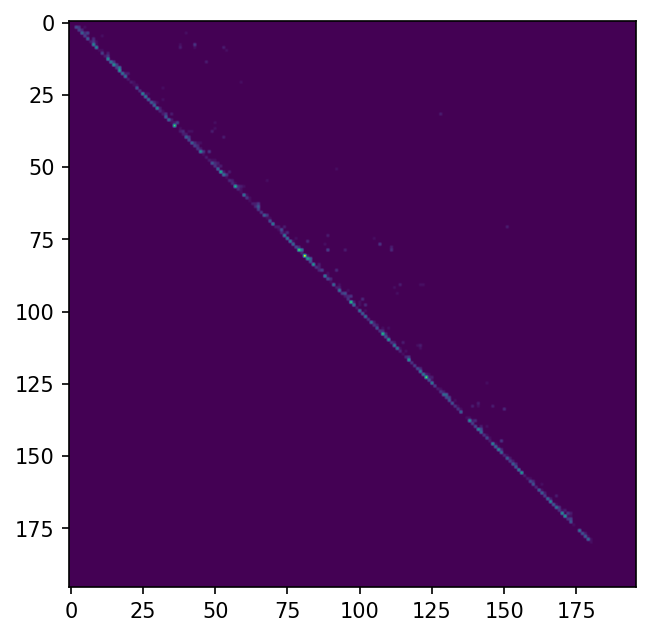

In [31]:
# get binary adjacency matrices


def getHic(df, bins, label1, label2):
    grped = df.groupby([label1, label2])['read_name'].count().reset_index() # NOTE: not counting unique here
    A = grped.pivot(*grped)
    
    binNames = [i for i in range(len(bins))]
    
#     A.columns = binNames
#     A.index = binNames||

    print(A.index.max())

    A = A.reindex(binNames, fill_value=0,  axis=0)
    A = A.reindex(binNames, fill_value=0,  axis=1)
    
    print(A.index.max())

    A = A.fillna(0)
    
    return A
    
    
    
reload(pcu)
reload(binning)

chomosome = 2
chromLength = assembly['Total length'].tolist()[0]

resolution = 1000000 # 1mb scale
chr2Bins = binning.getBins(chromLength, resolution)
label1 = 'bin1'
label2 = 'bin2'

binaryMatrices = {}

for runId, chr2 in filteredCellsChr2.items():
    print(f"{runId=}")
    
    chr2 = binning.chromosomeBinData(chr2, 
                                     chr2Bins, 
                                     label1=label1, 
                                     label2=label2)
    
    A = getHic(chr2, chr2Bins, label1, label2)
#     plt.imshow(A.to_numpy())
    
    break
    
#     A = pcu.constructHiCSingleChromosome(chr2, log=False, binary=True)
#     print(f"{A.shape=}")
#     binaryMatrices[runId] = A
    
plt.imshow(A)
    
# print(f"{binaryMatrices.keys()=}")

In [6]:
test = binaryMatrices['run07']
test

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

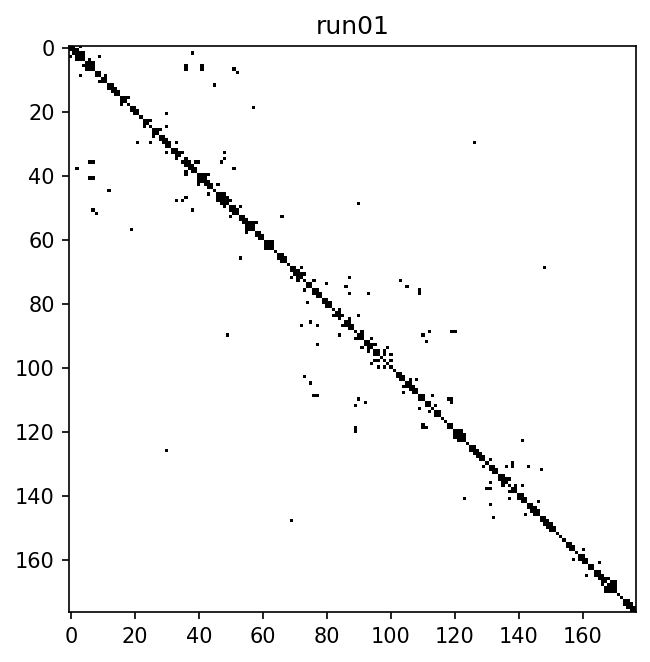

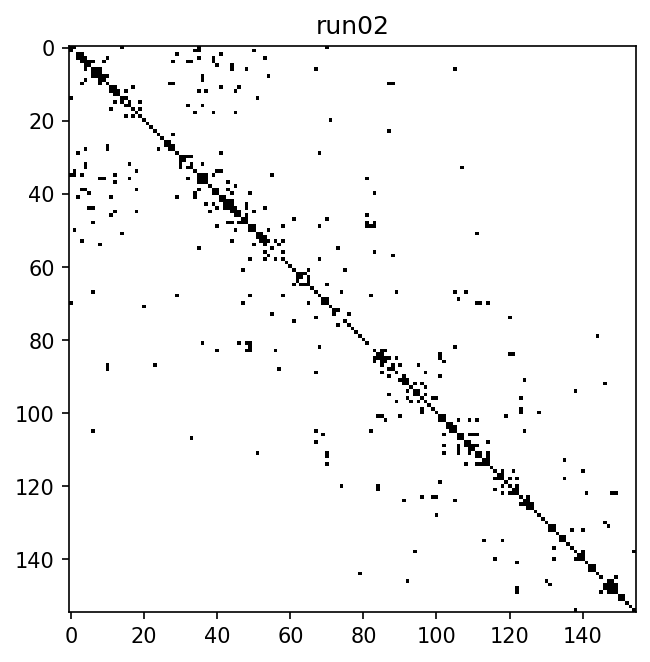

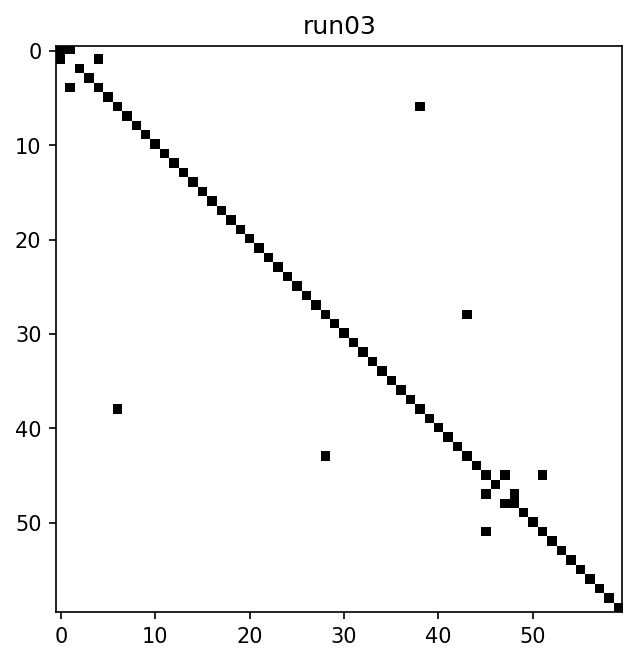

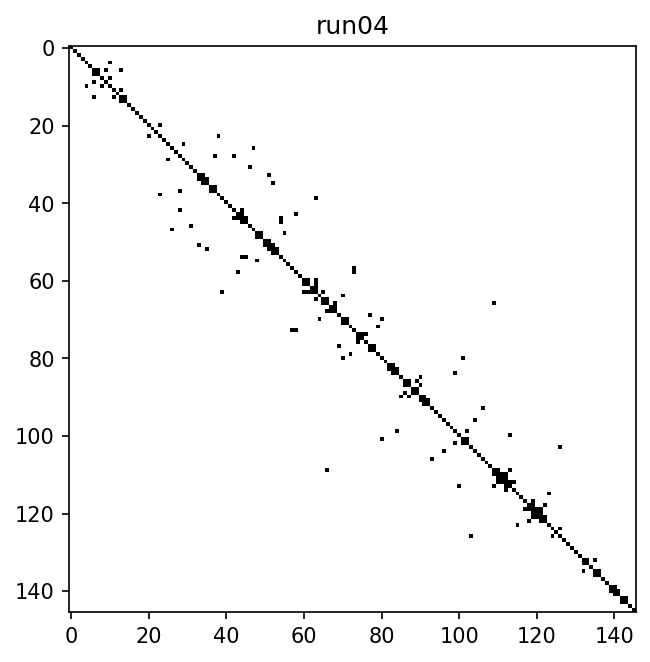

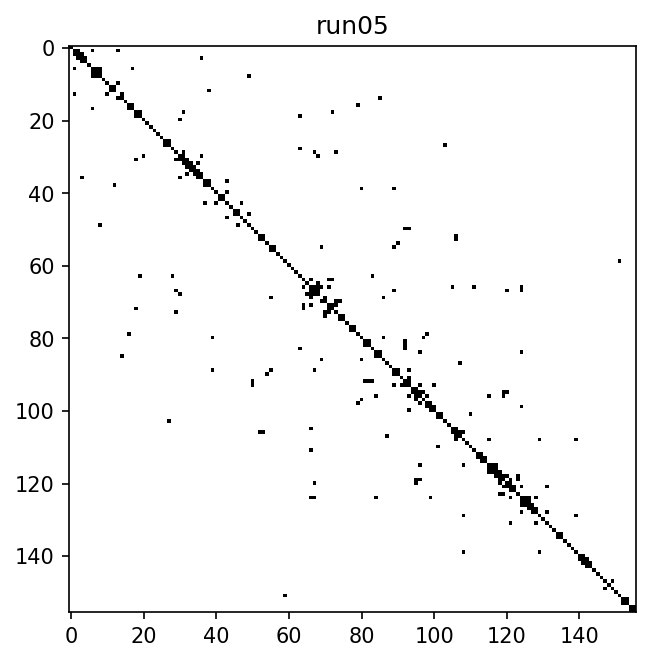

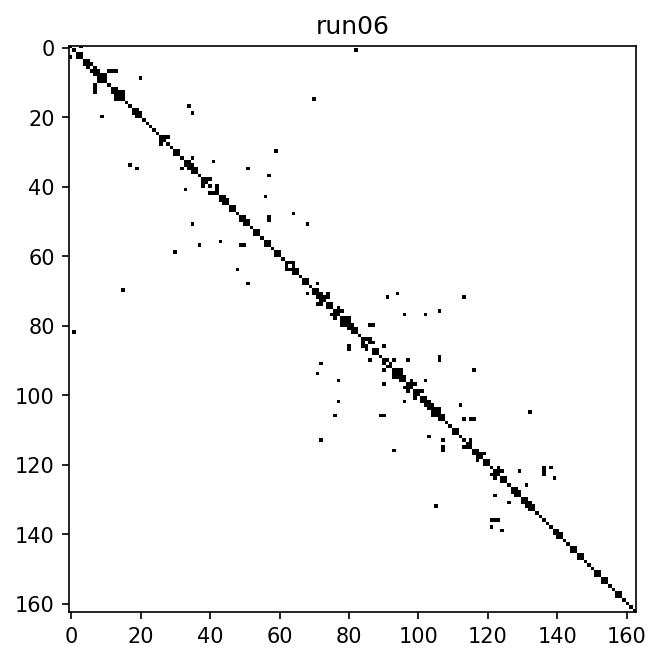

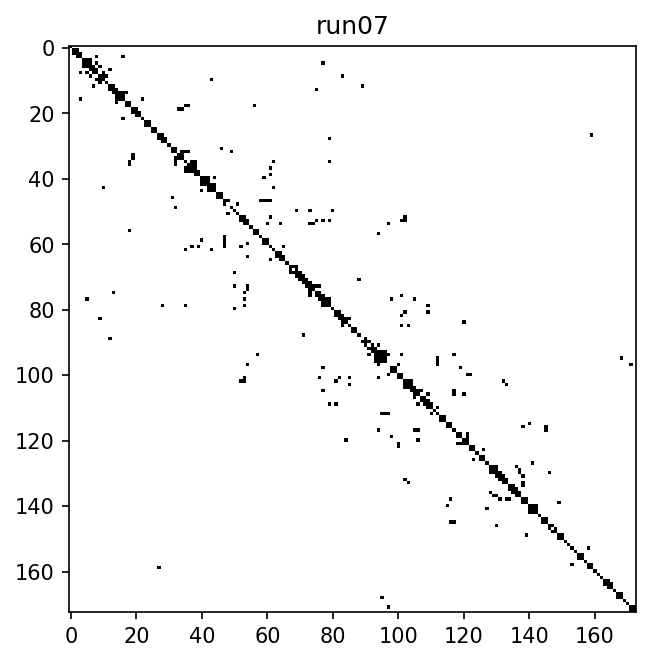

In [7]:
%matplotlib inline

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 5, 5

for runId, A in binaryMatrices.items():
    plt.imshow(A, cmap='binary')
    plt.title(runId)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [8]:
def robustContactMatrix(filteredContacts, bins,label1, label2):
    """A function to include every bin in matrix construction """
    n = len(bins)
    A = np.zeros((n,n))
    
    
    
# robustContactMatrix(filteredCellsChr2, chr2Bins, 
#                     label1, 
#                     label2)
    
    